The purpose of this notebook is to do some initial proof-of-concept work investigating various burn severity metrics within Joshua Tree National Park and Mojave Valley National Preserve.

Importing required packages:

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import requests
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
import contextily as ctx
import rasterio
import seaborn as sns
import pandas as pd
import xarray as xr
from src.query_sentinel import Sentinel2Client
from src.ingest_BARC import ingest_BARC_zip_file

In [4]:
SENTINEL2_PATH = "https://earth-search.aws.element84.com/v1"
response = requests.get(SENTINEL2_PATH)
print(response.json())

{'stac_version': '1.0.0', 'type': 'Catalog', 'id': 'earth-search-aws', 'title': 'Earth Search by Element 84', 'description': 'A STAC API of public datasets on AWS', 'links': [{'rel': 'self', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1'}, {'rel': 'root', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1'}, {'rel': 'conformance', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/conformance'}, {'rel': 'data', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/collections'}, {'rel': 'search', 'type': 'application/geo+json', 'href': 'https://earth-search.aws.element84.com/v1/search', 'method': 'GET'}, {'rel': 'search', 'type': 'application/geo+json', 'href': 'https://earth-search.aws.element84.com/v1/search', 'method': 'POST'}, {'rel': 'aggregate', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/aggregate', 'method': 'GET'}, {'rel': 'aggreg

The following is an excerpt from the [proposed scope of work](https://docs.google.com/document/d/1Mwad8O_T7LjNUSiKOD9egrlos9rd9EsNK09ABFrGQdA) between the NPS and DSE. Essentially, this notebook aims to validate the assumption baked into this proposal - that BAER / BARC maps (and the dNBR approach they employ) are insufficient estimates of burn severity in JOTR and MVNP. 

We will first investigate this by getting the BARC maps via the online portal, using the extent of those maps to query SentinelHub for sentinel2 data, and making some comparisons between the various classifications derived from each metric.

### Step 1 - Develop Data / Modelling Infrastructure

Inputs:
- High frequency, low spatial resolution, highest spectral resolution remote sensing data
	- `Sentinel-2`, ~~`LANDSAT`, `MODIS`~~
- ~~Low frequency, higher spatial resolution, low spectral resolution~~
	- ~~National Agricultural Imagery Program (`NAIP`)~~
- ~~One-off frequency, extremely high spatial resolution, variable spectral resolution~~
	- ~~LIDAR imagery from previous survey work~~

In the context of fire severity modelling, absolute metrics, such as the *Normalized Burn Ratio* ($NBR$), tend to be more effective for comparison across high and low biomass areas, but tend to be biased low in low biomass areas since the absolute changes ($dNBR$) are small in magnitude according to lack of adjustment. 

$$ NBR = \frac{NIR - SWIR}{NIR + SWIR} $$
$$ dNBR = NBR_{prefire} - NBR_{postfire}$$

To address these issues, some commonly accepted adjustments include the *Relative Difference in Normalized Burn Ratio* ($RdNBR$), as well as the *Relativized Burn Ratio* ($RBR$),  both of which attempt to adjust the relative change by the reflectance of the area pre-fire, such that fire severity is scaled to local reflectance in each given pixel.

$$RdNBR = \frac{dNBR}{|(NBR_{prefire})^{0.5}|}$$

$$ RBR = \frac{dNBR}{NBR_{prefire} +1.001}$$
Each of these metrics can be derived from satellite imagery, at various degrees of temporal and spatial resolution. The simplest approach would be to settle on one source (likely `Sentinel-2`, as it has the higher temporal resolution than `MODIS` and `LANDSAT`), and interpolate values between collection. However, a particular challenge identified in the case of immediate post-fire analysis is the potential occlusion of smoke - most approaches employ some manual approaches to find the best available pre-fire and post-fire images, which could lead to (1) some vegetative cover/biomass bias due phenology between image dates or (2) lag in analysis time in waiting for smoke-free imagery to be collected, since satellites return at best every 5 days. 

If we discover that relying on a imaging source is insufficient, either due to a lack of timeliness in imaging after fire (due to smoke or cloud occlusion) or simply due to issues with ground-truth accuracy (described in step 2), we may investigate a method which incorporates multiple imagery sources, as illustrated with `ESTARFM` fusion model employed in *Liu et. al. 2022*. 

First, we can grab the relevant data from the USGS' online portal (https://burnseverity.cr.usgs.gov/viewer/?product=BAER):

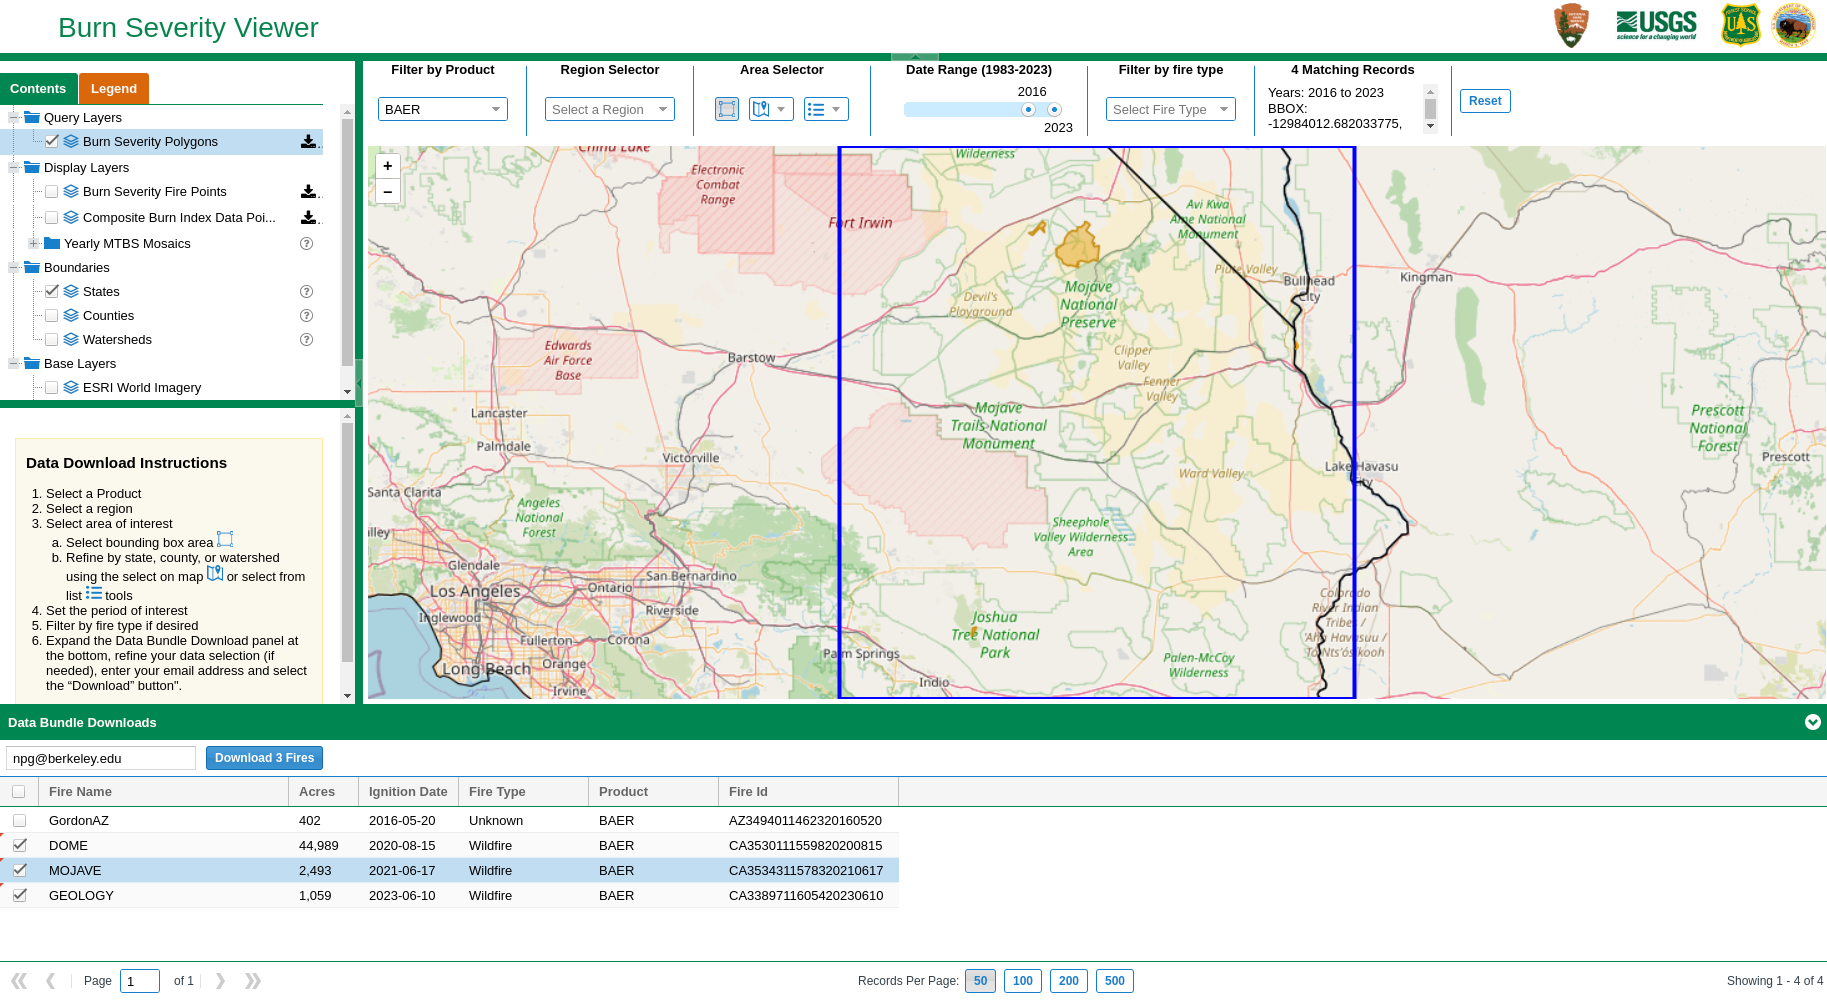

In [5]:
BARC_shps, BARC_tifs = ingest_BARC_zip_file("data/baer/2023/ca3389711605420230610.zip")

Found shapefile: ca3389711605420230610_20230603_20230619_burn_bndy.shp
Found tif file: ca3389711605420230610_20230603_20230619_dnbr.tif
Found tif file: ca3389711605420230610_20230603_20230619_dnbr_barc256.tif
Found tif file: ca3389711605420230610_20230603_20230619_dnbr_barc4.tif
Found shapefile: ca3389711605420230610_20230603_20230619_mask.shp
Found tif file: ca3389711605420230610_20230603_20230619_rdnbr.tif
Found tif file: ca3389711605420230610_20230603_L8_refl.tif
Found tif file: ca3389711605420230610_20230619_L8_refl.tif


In [6]:
barc_classifications = BARC_tifs[2]

dome_boundary = BARC_shps[0]
dome_boundary = dome_boundary.to_crs("EPSG:4326")


In [7]:
s2_client_dome = Sentinel2Client(
    geojson_bounds=dome_boundary.geometry,
    barc_classifications=barc_classifications,
    buffer=0.1
)

Initialized Sentinel2Client with bounds: [-116.16, 33.78, -115.93, 34.02]


In [8]:
s2_client_dome.query_fire_event(
    prefire_date_range=("2023-05-10", "2023-06-10"),
    postfire_date_range=("2023-06-25", "2023-07-25"),
)

/opt/conda/envs/burn-severity/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
/opt/conda/envs/burn-severity/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [9]:
s2_client_dome.calc_burn_metrics()

/opt/conda/envs/burn-severity/lib/python3.12/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [10]:
UN_THRESHOLDS = {
    -.25: -2.0,
    -.1: -1.0,
    0.1: 0.0,
    0.27: 1.0,
    0.44: 2.0,
    0.66: 3.0,
    1.30: 4.0
}

s2_client_dome.classify(
    UN_THRESHOLDS,
    'UN-SPYDER'
)

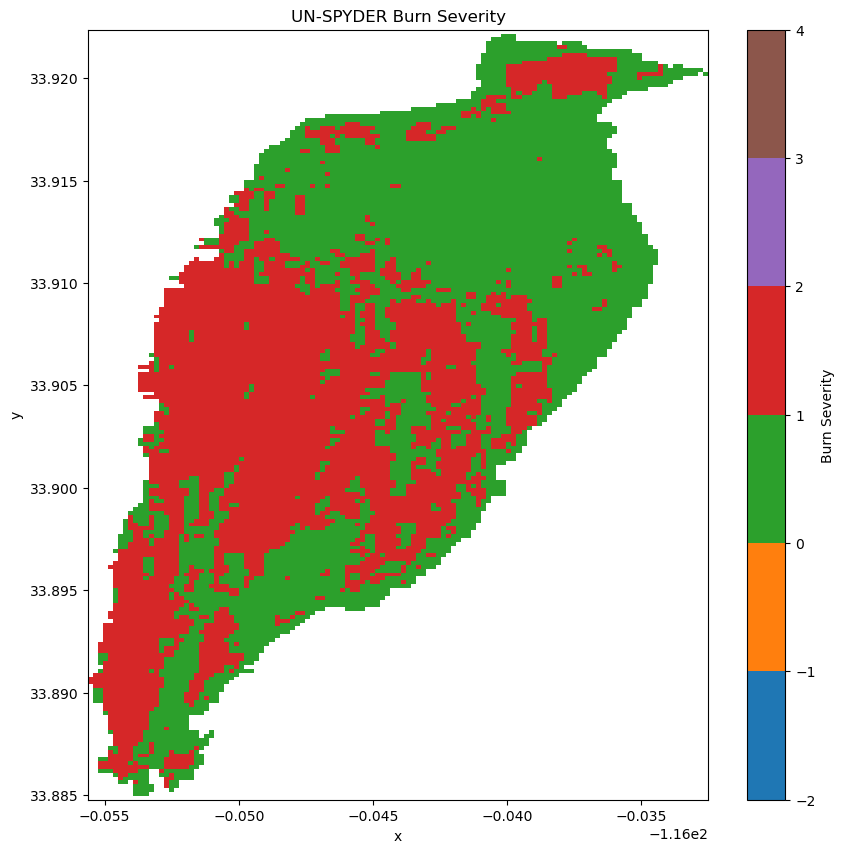

In [11]:
UN_THRESHOLDS_LABELS = {
    -2: "High Regrowth",
    -1: "Low Regrowth",
    0: "Unburned",
    1: "Low Severity",
    2: "Moderate-Low Severity",
    3: "Moderate-High Severity",
    4: "High Severity"
}

fig = plt.figure(figsize=(10, 10))
s2_client_dome.derived_classifications.sel(
    classification_source='UN-SPYDER'
).plot(
    x="x",
    y="y",
    # cmap="tab10",
    cbar_kwargs={'ticks': list(UN_THRESHOLDS_LABELS.keys()), 'label': 'Burn Severity'},
    levels=list(UN_THRESHOLDS_LABELS.keys()),
    colors=[f"C{i}" for i in range(len(UN_THRESHOLDS_LABELS))]
)
plt.title("UN-SPYDER Burn Severity", fontsize=12)
plt.show()


Plot burn metrics

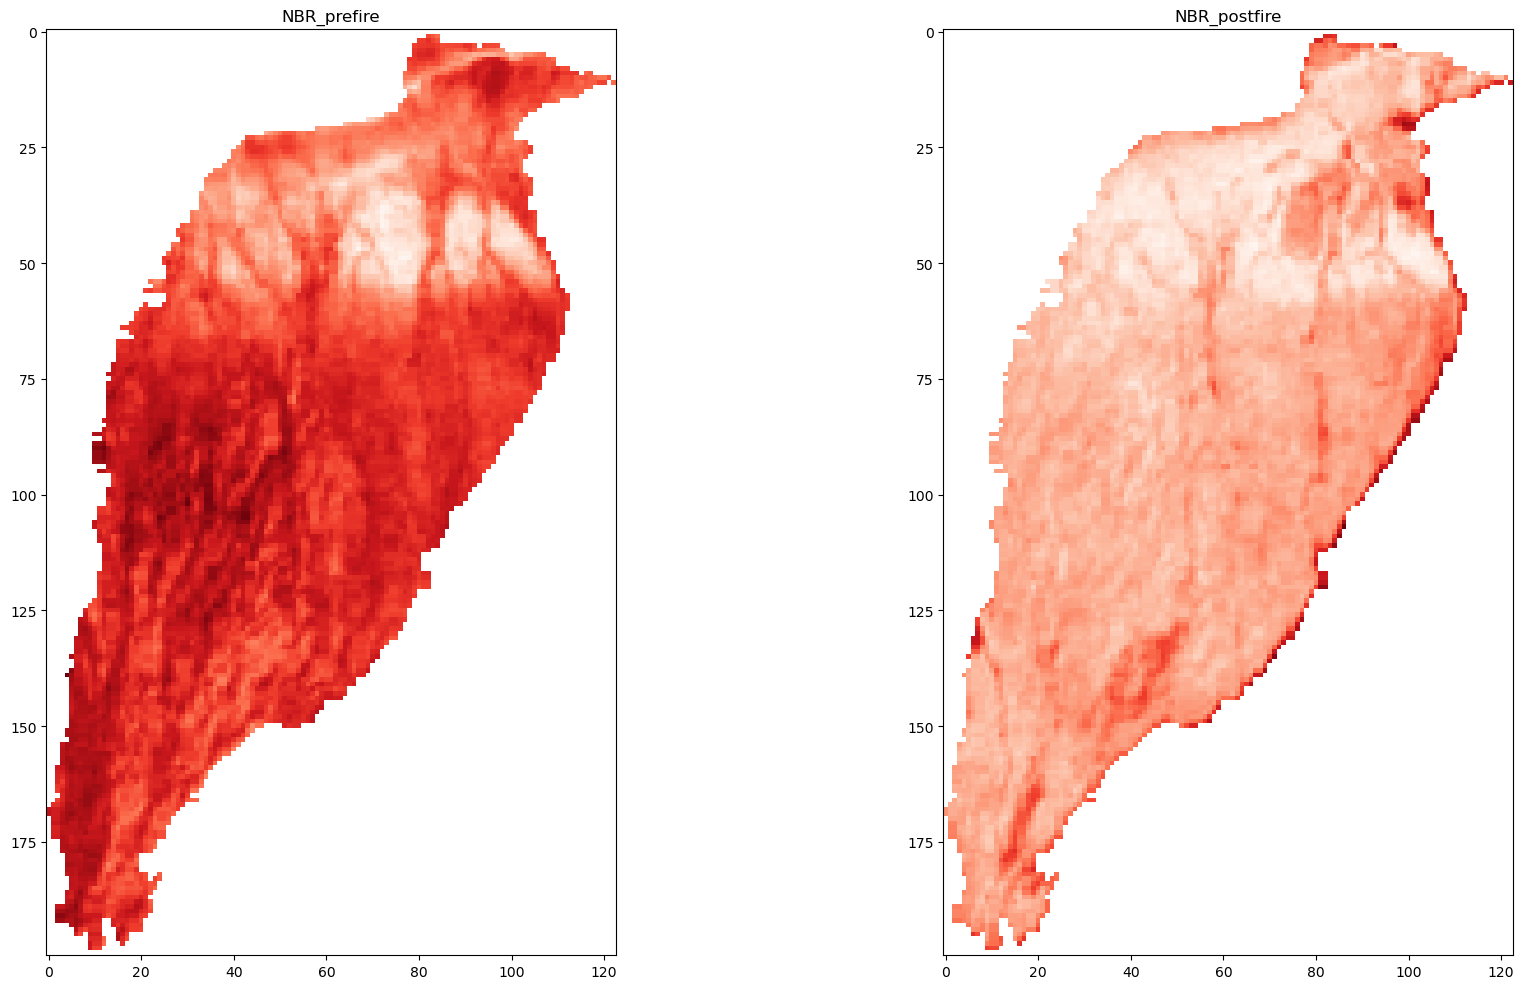

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot NBR_prefire
axes[0].imshow(s2_client_dome.metrics_stack.sel(burn_metric="nbr_prefire"), cmap="Reds")
axes[0].set_title("NBR_prefire")

# Plot NBR_postfire
axes[1].imshow(s2_client_dome.metrics_stack.sel(burn_metric="nbr_postfire"), cmap="Reds")
axes[1].set_title("NBR_postfire")

plt.tight_layout()
plt.show()


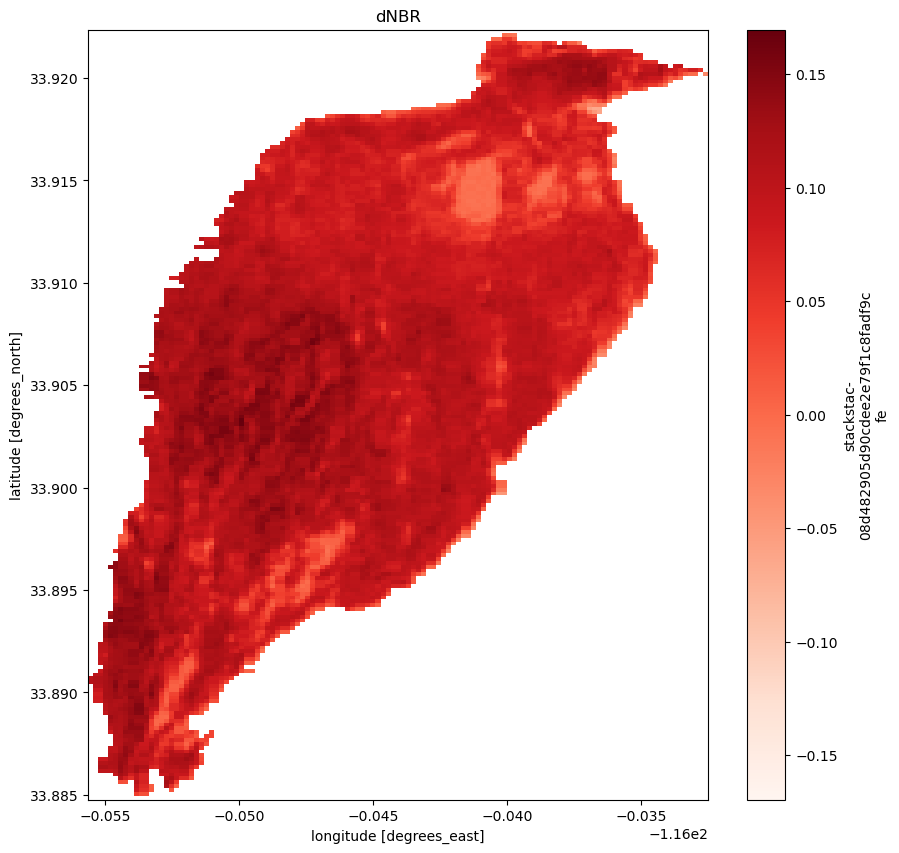

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# Plot DNBR
s2_client_dome.metrics_stack.sel(burn_metric="dnbr").plot(
    x="x",
    y="y",
    cmap="Reds",
    ax=ax,
)

plt.title("dNBR", fontsize=12)
plt.show()


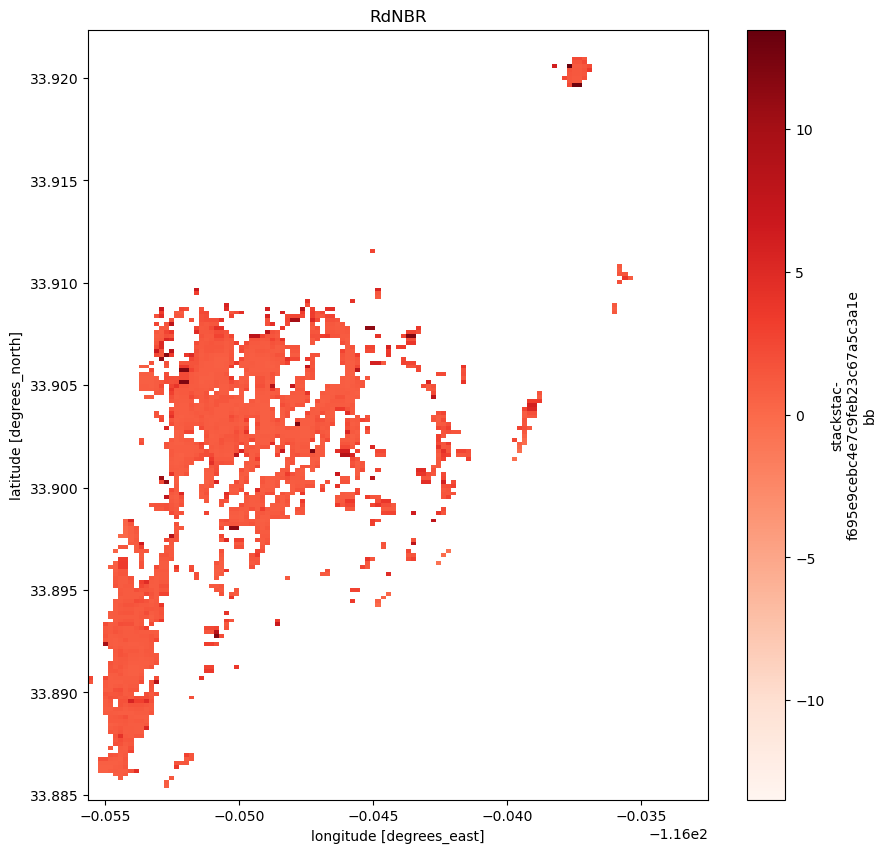

In [57]:
fig = plt.figure(figsize=(10, 10))
s2_client_dome.metrics_stack.sel(burn_metric="rdnbr").plot(
    x="x",
    y="y",
    cmap="Reds"
)
plt.title("RdNBR", fontsize=12)
plt.show()

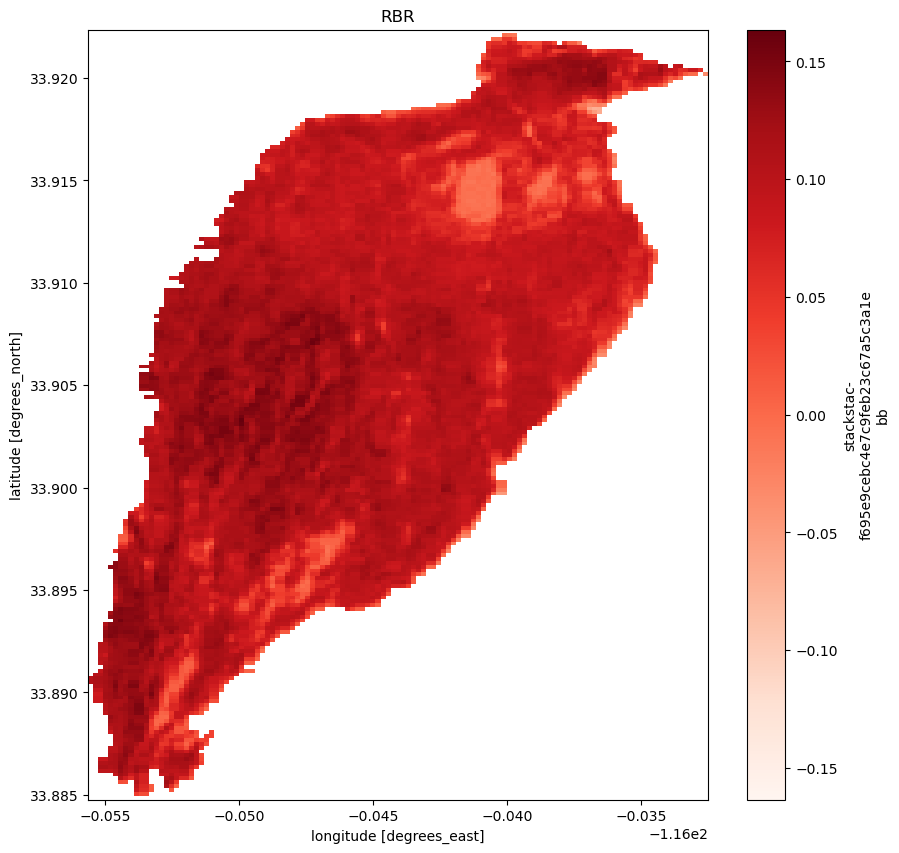

In [55]:
fig = plt.figure(figsize=(10, 10))
s2_client_dome.metrics_stack.sel(burn_metric="rbr").plot(
    x="x",
    y="y",
    cmap="Reds",
    # vmin=.35,
    # vmax=-.35
)
plt.title("RBR", fontsize=12)
plt.show()

RBR seems to shift the distribtion slightly... but overall, not too much. 

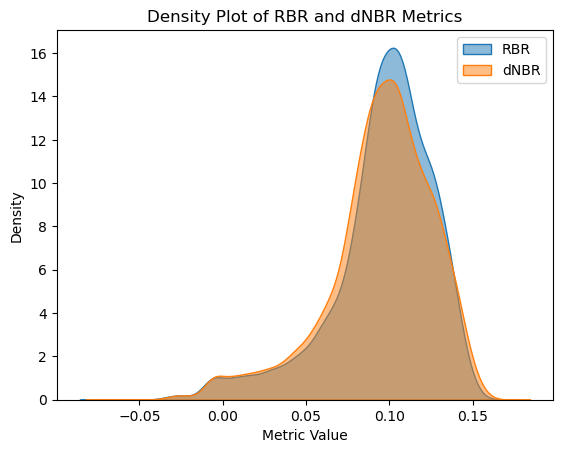

In [58]:
# Extract the RBR and dNBR metrics from the metrics stack
rbr = s2_client_dome.metrics_stack.sel(burn_metric="rbr").values.ravel()
dnbr = s2_client_dome.metrics_stack.sel(burn_metric="dnbr").values.ravel()

# Create a dataframe with the RBR and dNBR metrics
data = pd.DataFrame({'RBR': rbr, 'dNBR': dnbr})

# Plot the overlaid density plots
sns.kdeplot(data=data, x='RBR', fill=True, alpha=0.5, label='RBR')
sns.kdeplot(data=data, x='dNBR', fill=True, alpha=0.5, label='dNBR')

# Set the plot title and labels
plt.title('Density Plot of RBR and dNBR Metrics')
plt.xlabel('Metric Value')
plt.ylabel('Density')

# Show the legend
plt.legend()

# Show the plot
plt.show()


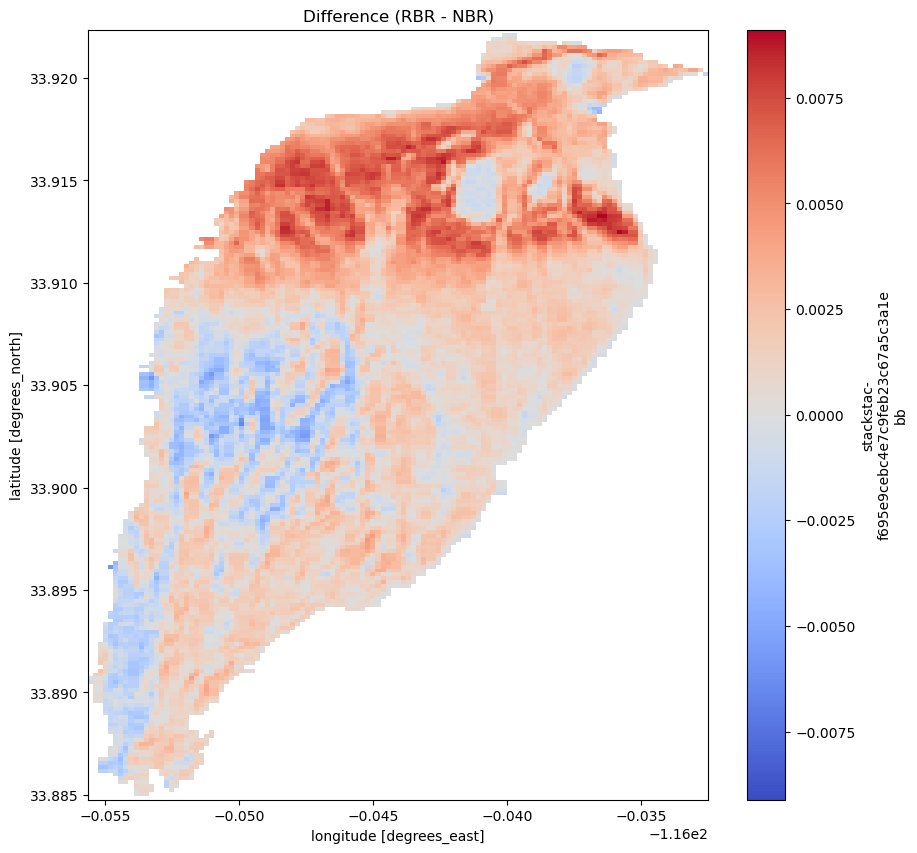

In [60]:
# Calculate the difference between RBR and dNBR
diff = s2_client_dome.metrics_stack.sel(burn_metric="rbr") - s2_client_dome.metrics_stack.sel(burn_metric="dnbr")

# Plot the difference map
fig = plt.figure(figsize=(10, 10))
diff.plot(
    x="x", y="y", cmap="coolwarm"
)
plt.title("Difference (RBR - NBR)", fontsize=12)
plt.show()


Can we approximate the BARC thresholds, to validate the assumption that they vary from fire to to fire?


In [61]:
import rasterio
from rasterio.warp import reproject
import xarray as xr
import numpy as np
import pandas as pd

def reproject_da(source_da, target_da):
    # Convert xarrays to numpy arrays
    src_array = np.array(source_da.to_masked_array())
    dest_array = np.array(target_da.to_masked_array())

    # Using 'bilinear' resampling.
    reproject(
        # Source parameters
        source=src_array,
        src_transform=source_da.rio.transform(), 
        src_crs=source_da.rio.crs,
        # Destination paramaters
        destination=dest_array, 
        dst_transform=target_da.rio.transform(),
        dst_crs=target_da.rio.crs,
        # Configuration
        resampling=rasterio.enums.Resampling.bilinear
    )
    
    # Convert result back to xarray DataArray
    reprojected_da = xr.DataArray(
        dest_array,
        dims=target_da.dims,
        coords=target_da.coords,
    )

    return reprojected_da

In [62]:
# Prepare the input and target data, dropping NaNs
X = s2_client_dome.metrics_stack.sel(burn_metric="dnbr")
y = s2_client_dome.barc_classifications.sel(band=1)

# Reproject X to y projection
X = reproject_da(X, y)
combined = xr.concat(
    [X,y],
    pd.Index(["train", "target"], name="data_type"))

In [63]:
from sklearn import tree
import numpy as np

train_data = combined.sel(data_type='train').values.ravel()
target_data = combined.sel(data_type='target').values.ravel()

non_nan_indices = np.logical_and(np.logical_not(np.isnan(train_data)),
                                 np.logical_not(np.isnan(target_data)))

train_data = train_data[non_nan_indices]
target_data = target_data[non_nan_indices]

# setting up a decision tree classifier
clf = tree.DecisionTreeClassifier(
    max_depth=2,
    max_leaf_nodes=3
)

# reshaping your data to fit it in the model
train_data = np.reshape(train_data,(-1,1))
target_data = np.reshape(target_data,(-1, 1))

# performing classification
clf = clf.fit(train_data, target_data)

[Text(0.4, 0.8333333333333334, 'x[0] <= 0.024\ngini = 0.06\nsamples = 3850\nvalue = [119, 3731]'),
 Text(0.2, 0.5, 'gini = 0.312\nsamples = 88\nvalue = [71, 17]'),
 Text(0.6, 0.5, 'x[0] <= 0.046\ngini = 0.025\nsamples = 3762\nvalue = [48, 3714]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.341\nsamples = 142\nvalue = [31, 111]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.009\nsamples = 3620\nvalue = [17, 3603]')]

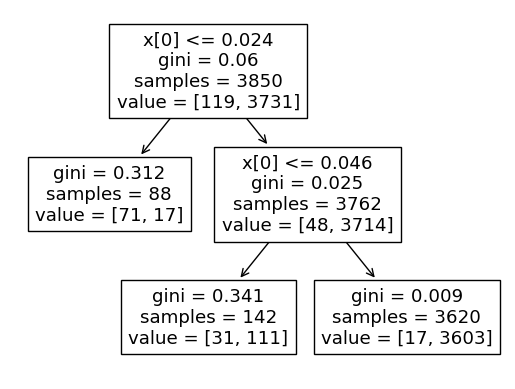

In [64]:
tree.plot_tree(clf)

In [65]:
DERIVED_BARC_THRESHOLD = {
    0.045: 1.0,
    0.222: 2.0,
    0.8: 3.0
}

s2_client_dome.classify(
    DERIVED_BARC_THRESHOLD,
    'DERIVED_BARC'
)

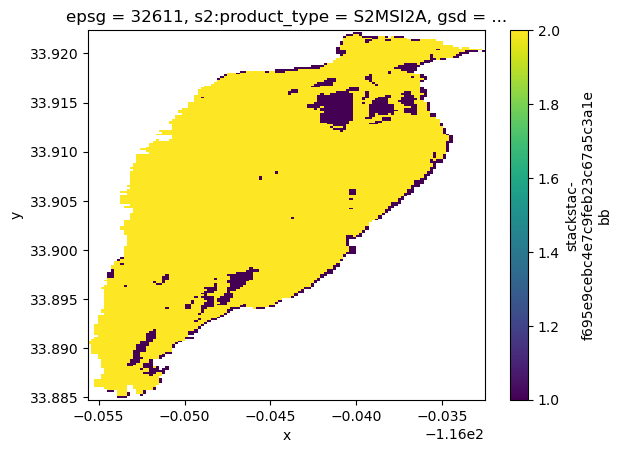

In [66]:
s2_client_dome.derived_classifications.sel(
    classification_source='DERIVED_BARC'
).plot()


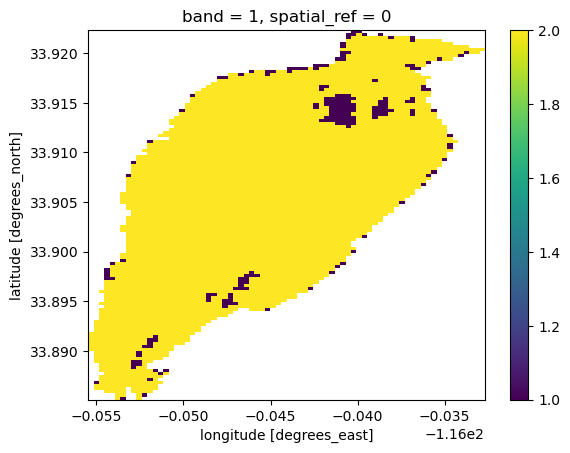

In [67]:
s2_client_dome.barc_classifications.plot()

For the purpose of illustration... what if we use the same threshold provided by BARC using the relative metric?